<a href="https://colab.research.google.com/github/SkyTong/DS440/blob/main/LSTM_1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
from dateutil import parser
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Conv1D, Input

#np.set_printoptions(threshold=np.inf)

# Load the dataset

In [ ]:
org_df = pd.read_csv('/content/processed_daily_data.csv',index_col=0)

In [ ]:
org_df

,Unnamed: 0,Date,SP500,DOW30,EuroStoxx50,NASDAQ,CrudeOil,SSE,Gold,VIX,...,transaction_count,transaction_count_all_time,large_transaction_count,average_transaction_value,block_height,hashrate,difficulty,block_time,block_size,current_supply
7,7.0,2022-02-07,4483.870117,35091.128906,4120.560059,14015.669922,91.320000,3429.580078,1820.599976,22.860001,...,262034,708920351,22948,18.010471,722252,1.807953e+08,2.669053e+13,634.059259,1220094,18951581
8,8.0,2022-02-08,4521.540039,35462.781250,4129.250000,14194.450195,89.360001,3452.629883,1826.599976,21.440001,...,276850,709197201,23752,43.189954,722406,2.046145e+08,2.669053e+13,560.248366,1269141,18952606
9,9.0,2022-02-09,4587.180176,35768.058594,4204.089844,14490.370117,89.660004,3479.949951,1835.199951,19.959999,...,265804,709463005,21082,20.272357,722546,1.854157e+08,2.669053e+13,618.258993,1412872,18953425
10,10.0,2022-02-10,4504.080078,35241.589844,4197.069824,14185.639648,89.879997,3485.909912,1836.199951,23.910000,...,260813,709723818,21476,20.544074,722693,1.945608e+08,2.669053e+13,589.198630,1389048,18954337
11,11.0,2022-02-11,4418.640137,34738.058594,4155.229980,13791.150391,93.099998,3462.949951,1840.800049,27.360001,...,258595,709982413,20452,15.155736,722835,1.912526e+08,2.669053e+13,599.390071,1526755,18955312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,745.0,2024-02-15,5029.729980,38773.121094,4743.169922,15906.169922,78.029999,2865.903076,2002.099976,14.010000,...,303306,965991635,24170,3.222092,830643,6.060194e+08,7.756333e+13,549.705128,2080268,19629025
746,746.0,2024-02-16,5005.569824,38627.988281,4765.649902,15775.650391,79.190002,2865.903076,2011.500000,14.240000,...,312782,966304417,21666,2.991963,830777,5.467598e+08,8.172530e+13,641.977444,1807967,19629862
747,747.0,2024-02-17,5005.569824,38627.988281,4765.649902,15775.650391,79.190002,2865.903076,2011.500000,14.240000,...,327713,966632130,16967,1.708139,830927,6.086717e+08,8.172530e+13,576.677852,1848949,19630800
748,748.0,2024-02-18,5005.569824,38627.988281,4765.649902,15775.650391,79.190002,2865.903076,2011.500000,14.240000,...,343417,966975547,15213,1.676919,831048,4.904280e+08,8.172530e+13,715.716667,1848168,19631556


In [ ]:

org_df = org_df.drop(org_df.columns[0], axis=1)

# Now org_df will have the first column removed
org_df


,Date,SP500,DOW30,EuroStoxx50,NASDAQ,CrudeOil,SSE,Gold,VIX,Nikkei225,...,transaction_count,transaction_count_all_time,large_transaction_count,average_transaction_value,block_height,hashrate,difficulty,block_time,block_size,current_supply
7,2022-02-07,4483.870117,35091.128906,4120.560059,14015.669922,91.320000,3429.580078,1820.599976,22.860001,27248.869141,...,262034,708920351,22948,18.010471,722252,1.807953e+08,2.669053e+13,634.059259,1220094,18951581
8,2022-02-08,4521.540039,35462.781250,4129.250000,14194.450195,89.360001,3452.629883,1826.599976,21.440001,27284.519531,...,276850,709197201,23752,43.189954,722406,2.046145e+08,2.669053e+13,560.248366,1269141,18952606
9,2022-02-09,4587.180176,35768.058594,4204.089844,14490.370117,89.660004,3479.949951,1835.199951,19.959999,27579.869141,...,265804,709463005,21082,20.272357,722546,1.854157e+08,2.669053e+13,618.258993,1412872,18953425
10,2022-02-10,4504.080078,35241.589844,4197.069824,14185.639648,89.879997,3485.909912,1836.199951,23.910000,27696.080078,...,260813,709723818,21476,20.544074,722693,1.945608e+08,2.669053e+13,589.198630,1389048,18954337
11,2022-02-11,4418.640137,34738.058594,4155.229980,13791.150391,93.099998,3462.949951,1840.800049,27.360001,27696.080078,...,258595,709982413,20452,15.155736,722835,1.912526e+08,2.669053e+13,599.390071,1526755,18955312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,2024-02-15,5029.729980,38773.121094,4743.169922,15906.169922,78.029999,2865.903076,2002.099976,14.010000,38157.941406,...,303306,965991635,24170,3.222092,830643,6.060194e+08,7.756333e+13,549.705128,2080268,19629025
746,2024-02-16,5005.569824,38627.988281,4765.649902,15775.650391,79.190002,2865.903076,2011.500000,14.240000,38487.238281,...,312782,966304417,21666,2.991963,830777,5.467598e+08,8.172530e+13,641.977444,1807967,19629862
747,2024-02-17,5005.569824,38627.988281,4765.649902,15775.650391,79.190002,2865.903076,2011.500000,14.240000,38487.238281,...,327713,966632130,16967,1.708139,830927,6.086717e+08,8.172530e+13,576.677852,1848949,19630800
748,2024-02-18,5005.569824,38627.988281,4765.649902,15775.650391,79.190002,2865.903076,2011.500000,14.240000,38487.238281,...,343417,966975547,15213,1.676919,831048,4.904280e+08,8.172530e+13,715.716667,1848168,19631556


In [ ]:
org_df.set_index('Date', inplace=True)
org_df.index

Index(['2022-02-07', '2022-02-08', '2022-02-09', '2022-02-10', '2022-02-11',
       '2022-02-12', '2022-02-13', '2022-02-14', '2022-02-15', '2022-02-16',
       ...
       '2024-02-10', '2024-02-11', '2024-02-12', '2024-02-13', '2024-02-14',
       '2024-02-15', '2024-02-16', '2024-02-17', '2024-02-18', '2024-02-19'],
      dtype='object', name='Date', length=743)

In [ ]:
org_df.columns

Index(['SP500', 'DOW30', 'EuroStoxx50', 'NASDAQ', 'CrudeOil', 'SSE', 'Gold',
       'VIX', 'Nikkei225', 'FTSE100', 'EURUSD', 'CNYUSD', 'GBPUSD', 'JPYUSD',
       'CHFUSD', 'BTC', 'zero_balance_addresses_all_time',
       'unique_addresses_all_time', 'new_addresses', 'active_addresses',
       'transaction_count', 'transaction_count_all_time',
       'large_transaction_count', 'average_transaction_value', 'block_height',
       'hashrate', 'difficulty', 'block_time', 'block_size', 'current_supply'],
      dtype='object')

# Features engineering

In [ ]:
org_df

,SP500,DOW30,EuroStoxx50,NASDAQ,CrudeOil,SSE,Gold,VIX,Nikkei225,FTSE100,...,transaction_count,transaction_count_all_time,large_transaction_count,average_transaction_value,block_height,hashrate,difficulty,block_time,block_size,current_supply
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-07,4483.870117,35091.128906,4120.560059,14015.669922,91.320000,3429.580078,1820.599976,22.860001,27248.869141,7573.500000,...,262034,708920351,22948,18.010471,722252,1.807953e+08,2.669053e+13,634.059259,1220094,18951581
2022-02-08,4521.540039,35462.781250,4129.250000,14194.450195,89.360001,3452.629883,1826.599976,21.440001,27284.519531,7567.100098,...,276850,709197201,23752,43.189954,722406,2.046145e+08,2.669053e+13,560.248366,1269141,18952606
2022-02-09,4587.180176,35768.058594,4204.089844,14490.370117,89.660004,3479.949951,1835.199951,19.959999,27579.869141,7643.399902,...,265804,709463005,21082,20.272357,722546,1.854157e+08,2.669053e+13,618.258993,1412872,18953425
2022-02-10,4504.080078,35241.589844,4197.069824,14185.639648,89.879997,3485.909912,1836.199951,23.910000,27696.080078,7672.399902,...,260813,709723818,21476,20.544074,722693,1.945608e+08,2.669053e+13,589.198630,1389048,18954337
2022-02-11,4418.640137,34738.058594,4155.229980,13791.150391,93.099998,3462.949951,1840.800049,27.360001,27696.080078,7661.000000,...,258595,709982413,20452,15.155736,722835,1.912526e+08,2.669053e+13,599.390071,1526755,18955312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-15,5029.729980,38773.121094,4743.169922,15906.169922,78.029999,2865.903076,2002.099976,14.010000,38157.941406,7597.500000,...,303306,965991635,24170,3.222092,830643,6.060194e+08,7.756333e+13,549.705128,2080268,19629025
2024-02-16,5005.569824,38627.988281,4765.649902,15775.650391,79.190002,2865.903076,2011.500000,14.240000,38487.238281,7711.700195,...,312782,966304417,21666,2.991963,830777,5.467598e+08,8.172530e+13,641.977444,1807967,19629862
2024-02-17,5005.569824,38627.988281,4765.649902,15775.650391,79.190002,2865.903076,2011.500000,14.240000,38487.238281,7711.700195,...,327713,966632130,16967,1.708139,830927,6.086717e+08,8.172530e+13,576.677852,1848949,19630800


# Dataset scalling

In [ ]:
dataset = org_df.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
#print('dataset.shape', dataset.shape)
num_of_features = len(org_df.columns)
print('Number of features', num_of_features)

Number of features 30


# Configuration

In [ ]:
expr_name = 'expr_16'
look_back = 60 # 60 days, as each entry is for 1 hour
lstm_layers = 50
epochs=25
batch_size=24

# spliting datasets into train and test

In [ ]:
train_size_percent = 0.80
pred_col = org_df.columns.get_loc('BTC')

# function to split the data
def create_dataset(dataset, pred_col, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), :]
    dataX.append(a)
    dataY.append(dataset[i + look_back, pred_col])
  return np.array(dataX), np.array(dataY)


train_size = int(len(dataset) * train_size_percent)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
testX, testY = create_dataset(test, pred_col, look_back=look_back)
# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))

print('Training dataset length ', len(train))
print('Testing dataset length ', len(test))
print('look_back ', look_back)

Training dataset length  594
Testing dataset length  149
look_back  60


# Build the model and train

In [ ]:
trainX.shape

(533, 60, 30)

In [ ]:
# create and fit the LSTM network

input_layer = Input(shape=(look_back,num_of_features))
conv1 = Conv1D(filters=32,
               kernel_size=8,
               strides=1,
               activation='relu',
               padding='same')(input_layer)
lstm1 = LSTM(lstm_layers)(conv1)
output_layer = Dense(1, activation='sigmoid')(lstm1)
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 60, 30)]          0         
                                                                 
 conv1d_6 (Conv1D)           (None, 60, 32)            7712      
                                                                 
 lstm_6 (LSTM)               (None, 50)                16600     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 24363 (95.17 KB)
Trainable params: 24363 (95.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
history= model.fit(trainX, trainY,validation_split=0.30, epochs=epochs, batch_size=batch_size,shuffle=False)

Epoch 1/25
16/16 [==============================] - 4s 93ms/step - loss: 0.0622 - val_loss: 0.0470
Epoch 2/25
16/16 [==============================] - 1s 31ms/step - loss: 0.0369 - val_loss: 0.0221
Epoch 3/25
16/16 [==============================] - 1s 33ms/step - loss: 0.0353 - val_loss: 0.0168
Epoch 4/25
16/16 [==============================] - 1s 32ms/step - loss: 0.0297 - val_loss: 0.0192
Epoch 5/25
16/16 [==============================] - 1s 33ms/step - loss: 0.0294 - val_loss: 0.0147
Epoch 6/25
16/16 [==============================] - 1s 32ms/step - loss: 0.0242 - val_loss: 0.0177
Epoch 7/25
16/16 [==============================] - 1s 32ms/step - loss: 0.0205 - val_loss: 0.0194
Epoch 8/25
16/16 [==============================] - 1s 33ms/step - loss: 0.0127 - val_loss: 0.0118
Epoch 9/25
16/16 [==============================] - 1s 33ms/step - loss: 0.0065 - val_loss: 0.0073
Epoch 10/25
16/16 [==============================] - 1s 32ms/step - loss: 0.0063 - val_loss: 0.0058
Epoch 11/

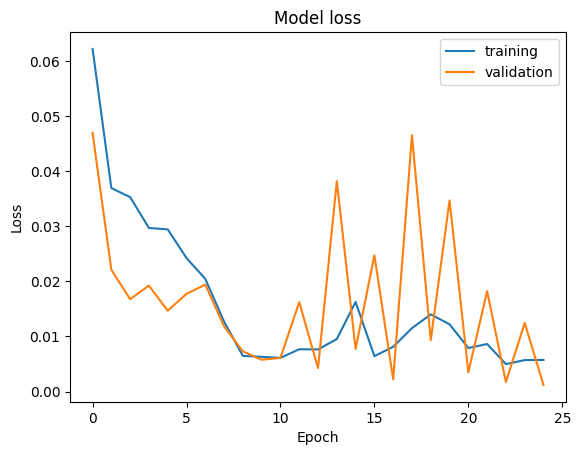

In [ ]:
# Plot training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [ ]:

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
# Put the predictions there
trainPredict_extended[:,pred_col] = trainPredict[:,0]
# Inverse transform it and select the 3rd column.
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),num_of_features))
# Put the predictions there
testPredict_extended[:,pred_col] = testPredict[:,0]
# Inverse transform it and select the pred_col column.
testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col]

trainY_extended = np.zeros((len(trainY),num_of_features))
trainY_extended[:,pred_col]=trainY
trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

testY_extended = np.zeros((len(testY),num_of_features))
testY_extended[:,pred_col]=testY
testY = scaler.inverse_transform(testY_extended)[:,pred_col]

# calculate root mean squared error
trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

# calculate absolute mean error
trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)


3/3 [==============================] - 0s 12ms/step


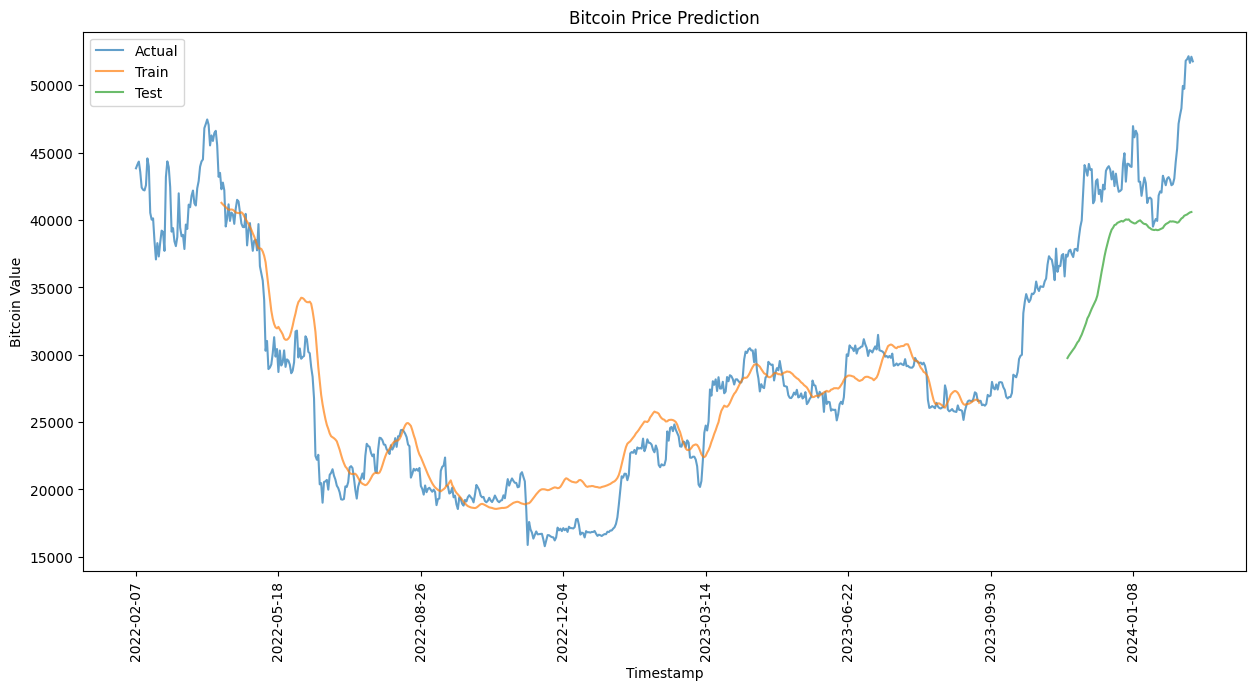

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, pred_col] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, pred_col] = testPredict

# contruct pandas dataframe for plotting
time_df = pd.DataFrame(org_df.index)
time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
df1 = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
df2 = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=False)
time_df2.set_index('Date',inplace=True)

# plot the output
fig, ax = plt.subplots(figsize=(15,7))
time_df2.plot(ax=ax,rot=90,alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Bitcoin Value')
plt.title('Bitcoin Price Prediction')
plt.savefig(expr_name + '.png',bbox_inches = "tight")

In [ ]:
print('-' * 50)
print('Experiment name:', expr_name)

print('-' * 50)
print('look_back days:', look_back/24)
print('lstm_layers:', lstm_layers)
print('epochs:', epochs)
print('batch_size:', batch_size)
print('dataset features', list(org_df.columns))


print('-' * 50)
print('Train Score: %.2f RMSE' % (trainScore_RMSE))
print('Test Score: %.2f RMSE' % (testScore_RMSE))

print('-' * 50)
print('Train Score: %.2f MAE' % (trainScore_MAE))
print('Test Score: %.2f MAE' % (testScore_MAE))

print('-' * 50)
print('Model summary:')
model.summary()

--------------------------------------------------
Experiment name: expr_16
--------------------------------------------------
look_back days: 2.5
lstm_layers: 50
epochs: 25
batch_size: 24
dataset features ['SP500', 'DOW30', 'EuroStoxx50', 'NASDAQ', 'CrudeOil', 'SSE', 'Gold', 'VIX', 'Nikkei225', 'FTSE100', 'EURUSD', 'CNYUSD', 'GBPUSD', 'JPYUSD', 'CHFUSD', 'BTC', 'zero_balance_addresses_all_time', 'unique_addresses_all_time', 'new_addresses', 'active_addresses', 'transaction_count', 'transaction_count_all_time', 'large_transaction_count', 'average_transaction_value', 'block_height', 'hashrate', 'difficulty', 'block_time', 'block_size', 'current_supply']
--------------------------------------------------
Train Score: 2204.74 RMSE
Test Score: 6446.79 RMSE
--------------------------------------------------
Train Score: 1709.89 MAE
Test Score: 5644.24 MAE
--------------------------------------------------
Model summary:
Model: "model_6"
______________________________________________________